### Project



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.classification.interval_based import TimeSeriesForestClassifier
from pyts.classification import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
# Load the dataset
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep='\s+', header=None)
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep='\s+', header=None)

# Preview first few rows
print(test_df.head())
print(train_df.head())

   0   1       2       3      4       5       6        7        8      9    
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62  \
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

   ...      16       17       18      19    20   21    22     23     24   
0  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0  38.86  \
1  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0  39.02   
2  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0  39.08   
3  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0  39.00   
4  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0  38.99   

        25  
0  23.3735  
1  23.3916  
2  23.4166  
3  23.3737  
4  23.4130  

[5 rows

In [3]:
# Define column names based on the provided structure from pdf
column_names = [
    "Unit", "ctime", "Setting1", "Setting2", "Setting3",
    "inlet_temp", "LPC_Temp_Out", "HPC_Temp_Out", "LPT_Temp_Out",
    "Fan_Pressure_In", "Total_Pressure_Bypass", "HPC_Pressure_Out",
    "Fan_Speed", "Core_Speed", "Engine_Pressure_Ratio", "HPC_Static_Pressure",
    "Fuel/Pressure_Ratio", "Fan_Speed_Correct", "Core_Speed_Correct",
    "ByPass_Ratio", "Fuel/Air_Ratio", "Bleed_Enthalpy", "Demanded_Fan_Speed",
    "Demand_Fan_Speed_Correct", "HPT_Coolant_Bleed", "LPT_Coolant_Bleed",
    "Null", "Null2"
]

# Load train and test data
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep="\s+", header=None, names=column_names)
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep="\s+", header=None, names=column_names)

# Drop unnecessary columns
train_df.drop(columns=["Null", "Null2"], inplace=True)
test_df.drop(columns=["Null", "Null2"], inplace=True)

# Display first few rows for both train and test dataset
print(train_df.head())
print(test_df.head())


   Unit  ctime  Setting1  Setting2  Setting3  inlet_temp  LPC_Temp_Out   
0     1      1   -0.0007   -0.0004     100.0      518.67        641.82  \
1     1      2    0.0019   -0.0003     100.0      518.67        642.15   
2     1      3   -0.0043    0.0003     100.0      518.67        642.35   
3     1      4    0.0007    0.0000     100.0      518.67        642.35   
4     1      5   -0.0019   -0.0002     100.0      518.67        642.37   

   HPC_Temp_Out  LPT_Temp_Out  Fan_Pressure_In  ...  Fuel/Pressure_Ratio   
0       1589.70       1400.60            14.62  ...               521.66  \
1       1591.82       1403.14            14.62  ...               522.28   
2       1587.99       1404.20            14.62  ...               522.42   
3       1582.79       1401.87            14.62  ...               522.86   
4       1582.85       1406.22            14.62  ...               522.19   

   Fan_Speed_Correct  Core_Speed_Correct  ByPass_Ratio  Fuel/Air_Ratio   
0            2388.02    

In [4]:
print(train_df.dtypes)



Unit                          int64
ctime                         int64
Setting1                    float64
Setting2                    float64
Setting3                    float64
inlet_temp                  float64
LPC_Temp_Out                float64
HPC_Temp_Out                float64
LPT_Temp_Out                float64
Fan_Pressure_In             float64
Total_Pressure_Bypass       float64
HPC_Pressure_Out            float64
Fan_Speed                   float64
Core_Speed                  float64
Engine_Pressure_Ratio       float64
HPC_Static_Pressure         float64
Fuel/Pressure_Ratio         float64
Fan_Speed_Correct           float64
Core_Speed_Correct          float64
ByPass_Ratio                float64
Fuel/Air_Ratio              float64
Bleed_Enthalpy                int64
Demanded_Fan_Speed            int64
Demand_Fan_Speed_Correct    float64
HPT_Coolant_Bleed           float64
LPT_Coolant_Bleed           float64
dtype: object


In [5]:
print(train_df.isnull().sum())


Unit                        0
ctime                       0
Setting1                    0
Setting2                    0
Setting3                    0
inlet_temp                  0
LPC_Temp_Out                0
HPC_Temp_Out                0
LPT_Temp_Out                0
Fan_Pressure_In             0
Total_Pressure_Bypass       0
HPC_Pressure_Out            0
Fan_Speed                   0
Core_Speed                  0
Engine_Pressure_Ratio       0
HPC_Static_Pressure         0
Fuel/Pressure_Ratio         0
Fan_Speed_Correct           0
Core_Speed_Correct          0
ByPass_Ratio                0
Fuel/Air_Ratio              0
Bleed_Enthalpy              0
Demanded_Fan_Speed          0
Demand_Fan_Speed_Correct    0
HPT_Coolant_Bleed           0
LPT_Coolant_Bleed           0
dtype: int64


In [6]:
# Set the failure time as the maximum ctime for each unit in training data
train_df['failure_time'] = train_df.groupby('Unit')['ctime'].transform('max')

# Display the first few rows of new training data
print(train_df[['Unit', 'ctime', 'failure_time']].head())


   Unit  ctime  failure_time
0     1      1           192
1     1      2           192
2     1      3           192
3     1      4           192
4     1      5           192


In [7]:
print(train_df.columns)

Index(['Unit', 'ctime', 'Setting1', 'Setting2', 'Setting3', 'inlet_temp',
       'LPC_Temp_Out', 'HPC_Temp_Out', 'LPT_Temp_Out', 'Fan_Pressure_In',
       'Total_Pressure_Bypass', 'HPC_Pressure_Out', 'Fan_Speed', 'Core_Speed',
       'Engine_Pressure_Ratio', 'HPC_Static_Pressure', 'Fuel/Pressure_Ratio',
       'Fan_Speed_Correct', 'Core_Speed_Correct', 'ByPass_Ratio',
       'Fuel/Air_Ratio', 'Bleed_Enthalpy', 'Demanded_Fan_Speed',
       'Demand_Fan_Speed_Correct', 'HPT_Coolant_Bleed', 'LPT_Coolant_Bleed',
       'failure_time'],
      dtype='object')


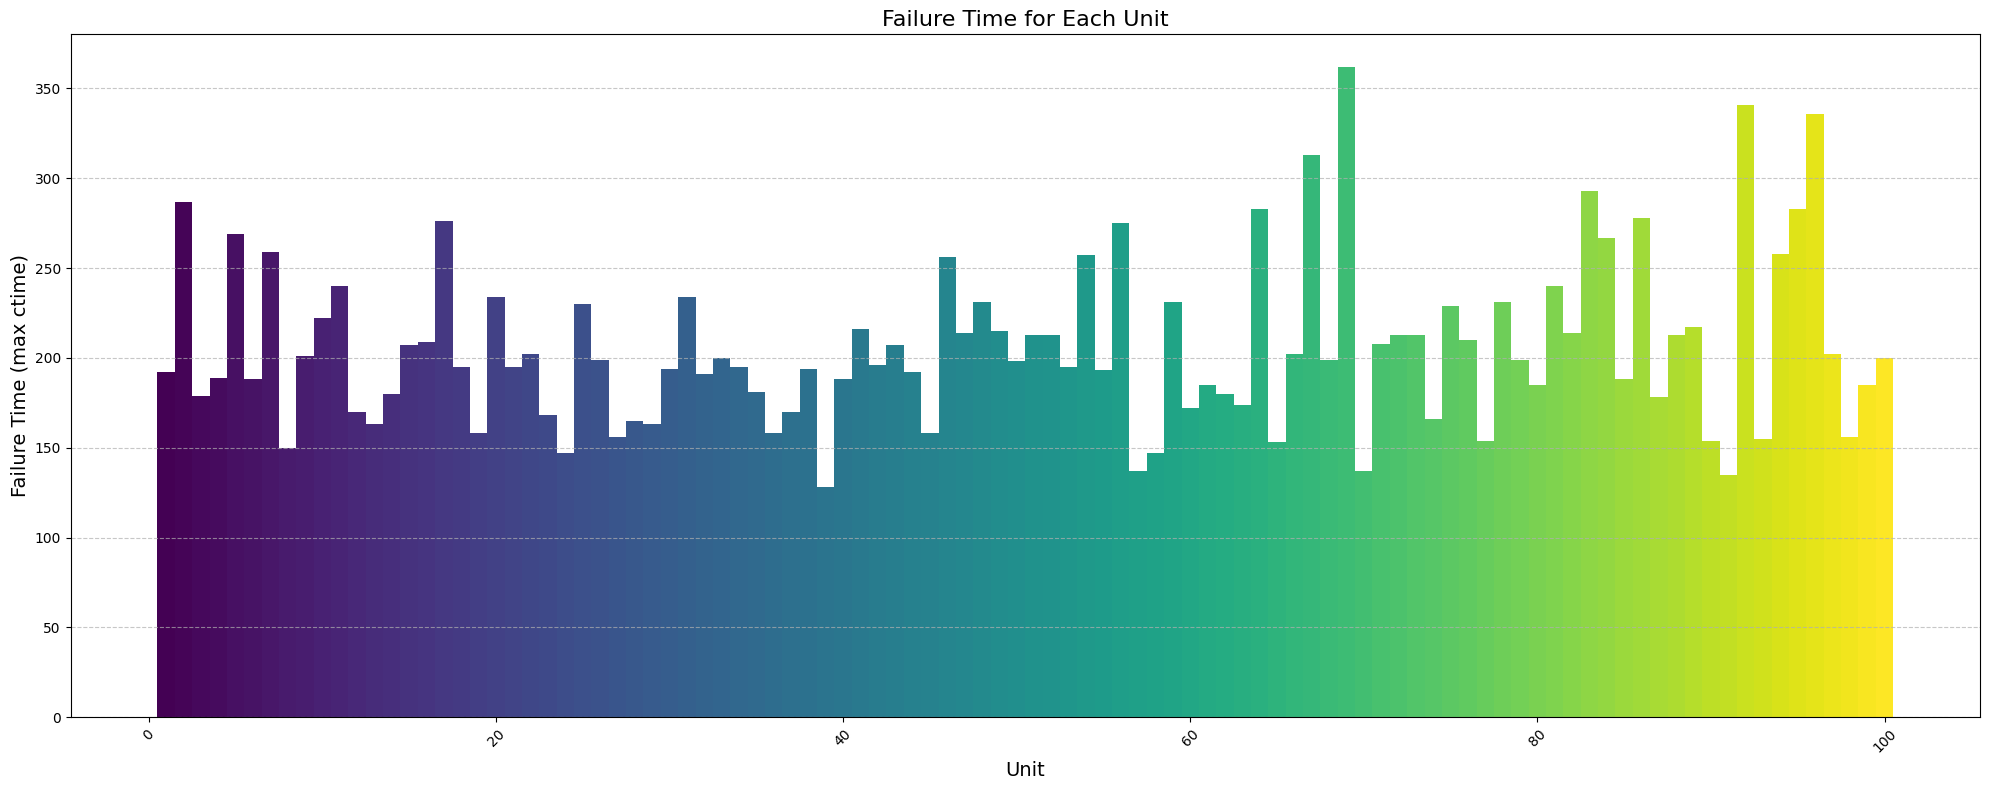

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors using colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(train_df['Unit'].unique())))

# Plot failure times for each unit
plt.figure(figsize=(20, 8))
for i, unit in enumerate(sorted(train_df['Unit'].unique())):
    unit_data = train_df[train_df['Unit'] == unit]
    plt.bar(unit, unit_data['failure_time'].max(), color=colors[i], width=1.0)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Failure Time (max ctime)', fontsize=14)
plt.xlabel('Unit', fontsize=14)
plt.title('Failure Time for Each Unit', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()






## Random Forest Regressor Method

In [9]:
# Define feature columns
feature_columns = [
    "Setting1", "Setting2", "Setting3",
    "inlet_temp", "LPC_Temp_Out", "HPC_Temp_Out", "LPT_Temp_Out",
    "Fan_Pressure_In", "Total_Pressure_Bypass", "HPC_Pressure_Out",
    "Fan_Speed", "Core_Speed", "Engine_Pressure_Ratio", "HPC_Static_Pressure",
    "Fuel/Pressure_Ratio", "Fan_Speed_Correct", "Core_Speed_Correct",
    "ByPass_Ratio", "Fuel/Air_Ratio", "Bleed_Enthalpy", "Demanded_Fan_Speed",
    "Demand_Fan_Speed_Correct", "HPT_Coolant_Bleed", "LPT_Coolant_Bleed"
]

X_train = train_df[feature_columns]
y_train = train_df['failure_time']

# Split data to training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Training Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_split, y_train_split)

# Evaluate the model
y_pred = regressor.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Validation MSE: {mse}, R2: {r2}")




Validation MSE: 2245.4518466925124, R2: 0.05237864314732166


In [10]:
# Predict failure time for test data
X_test = train_df[feature_columns]
train_df['predicted_failure_time'] = regressor.predict(X_test)

# Display test data with predictions
print(train_df[['Unit', 'ctime', 'predicted_failure_time']].head())




   Unit  ctime  predicted_failure_time
0     1      1                  242.28
1     1      2                  191.17
2     1      3                  211.76
3     1      4                  235.46
4     1      5                  213.17


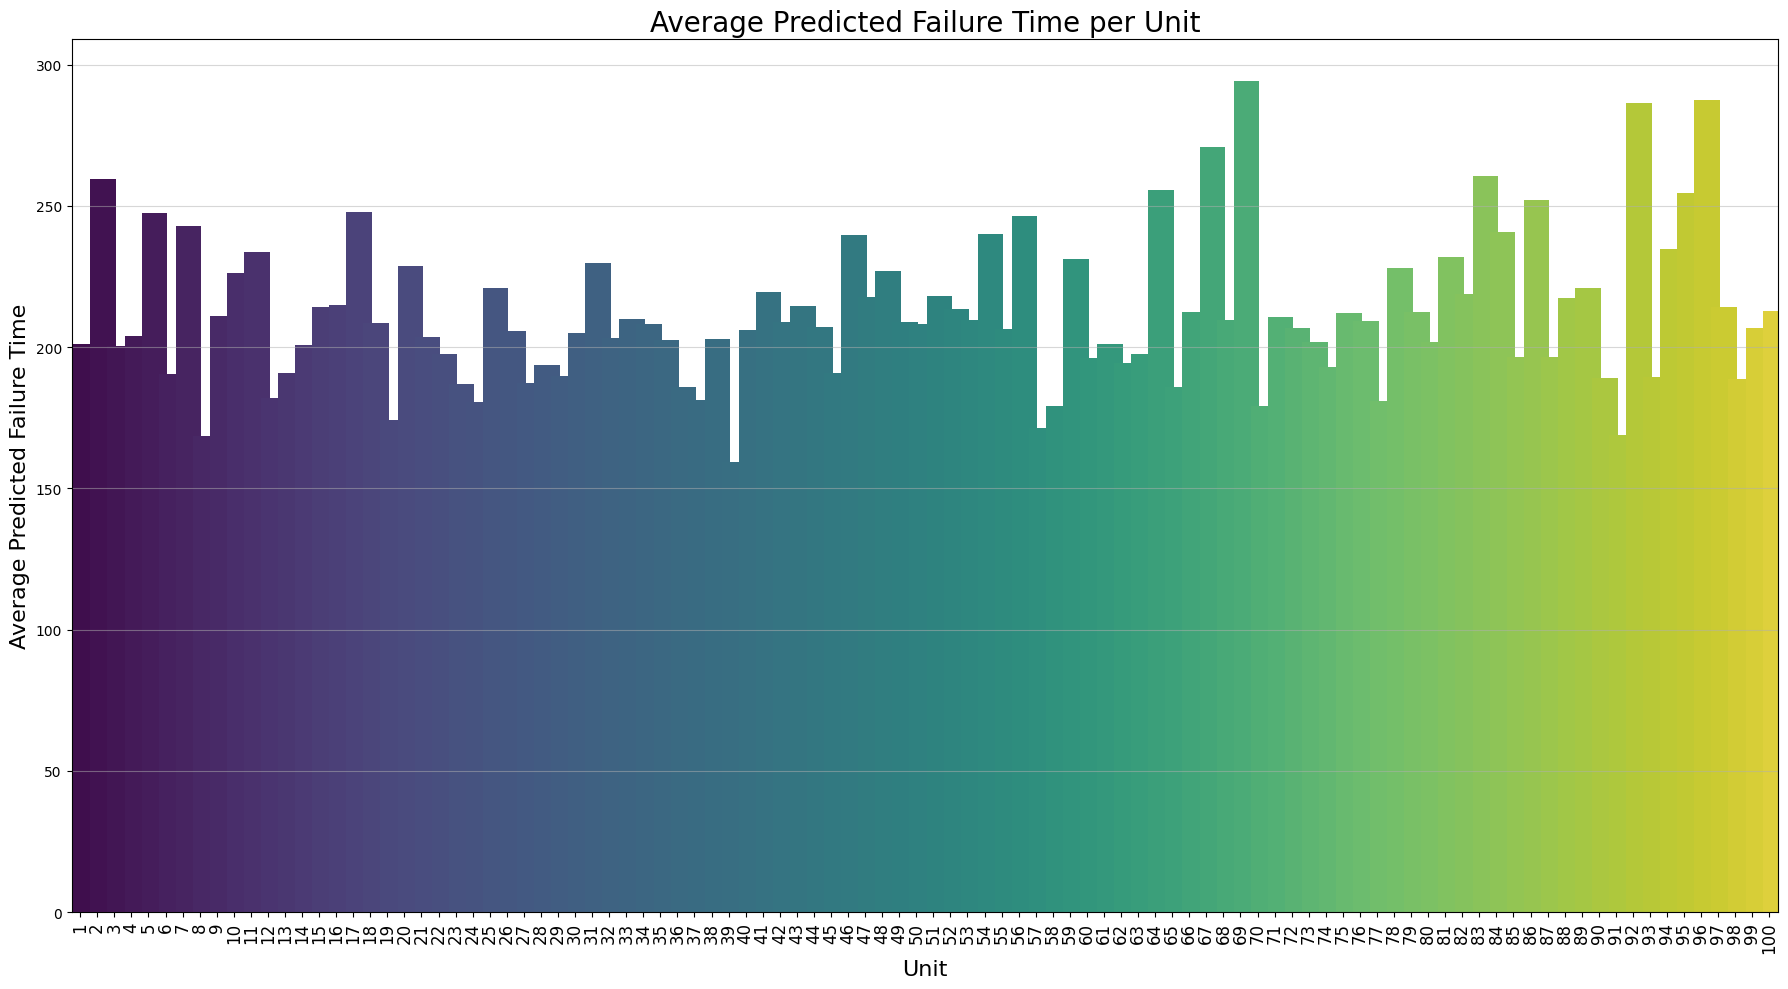

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean predicted failure time for each Unit
unit_summary = train_df.groupby('Unit')['predicted_failure_time'].mean().reset_index()
plt.figure(figsize=(18, 10))

# Create bar plot with thicker bars
barplot = sns.barplot(
    x='Unit', 
    y='predicted_failure_time', 
    data=unit_summary, 
    palette='viridis'
)

# Adjust bar width by setting edge width and spacing
for bar in barplot.patches:
    bar.set_width(1.5)  # Increase bar thickness

# Plot labeling
plt.xticks(rotation=90, fontsize=12)
plt.title('Average Predicted Failure Time per Unit', fontsize=20)
plt.xlabel('Unit', fontsize=16)
plt.ylabel('Average Predicted Failure Time', fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout() 
plt.show()



                     Feature  Importance
16        Core_Speed_Correct    0.131574
11                Core_Speed    0.077700
5               HPC_Temp_Out    0.070645
17              ByPass_Ratio    0.070123
23         LPT_Coolant_Bleed    0.068858
6               LPT_Temp_Out    0.068566
9           HPC_Pressure_Out    0.065330
14       Fuel/Pressure_Ratio    0.064823
4               LPC_Temp_Out    0.063788
0                   Setting1    0.061990
13       HPC_Static_Pressure    0.056060
22         HPT_Coolant_Bleed    0.054265
15         Fan_Speed_Correct    0.044545
10                 Fan_Speed    0.044425
1                   Setting2    0.035395
19            Bleed_Enthalpy    0.020918
8      Total_Pressure_Bypass    0.000996
7            Fan_Pressure_In    0.000000
3                 inlet_temp    0.000000
2                   Setting3    0.000000
18            Fuel/Air_Ratio    0.000000
20        Demanded_Fan_Speed    0.000000
21  Demand_Fan_Speed_Correct    0.000000
12     Engine_Pr

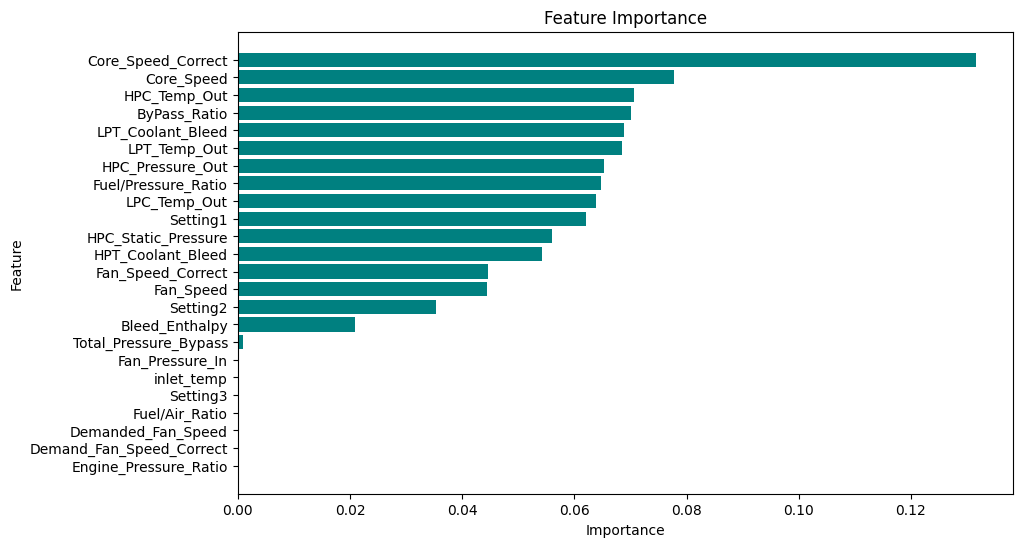

In [12]:
# Analyze feature importance from training model
# Get feature importances from Random Forest model
feature_importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## Grid Search for Random Forest Regressor

In [13]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "max_samples": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3, verbose=2
)

grid_search.fit(X_train_split, y_train_split)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_val)
mse_tuned = mean_squared_error(y_val, y_pred_tuned)
r2_tuned = r2_score(y_val, y_pred_tuned)

print(f"Tuned Validation MSE: {mse_tuned}, R2: {r2_tuned}")
print(f"Best Parameters: {grid_search.best_params_}")



Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=100; total time=   8.7s
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=100; total time=   8.6s
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=100; total time=   8.7s
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=200; total time=  17.9s
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=200; total time=  17.1s
[CV] END ....max_depth=10, max_samples=0.8, n_estimators=200; total time=  17.2s
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=100; total time=   9.7s
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=100; total time=   9.8s
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=100; total time=  10.0s
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=200; total time=  19.7s
[CV] END ....max_depth=10, max_samples=1.0, n_estimators=200; total time=  19.5s
[CV] END ....max_depth=10, max_samples=1.0, n_est

Tuned Validation MSE: 2212.624946285924, R2: 0.06623218979557399
Best Parameters: {'max_depth': 10, 'max_samples': 0.8, 'n_estimators': 200}


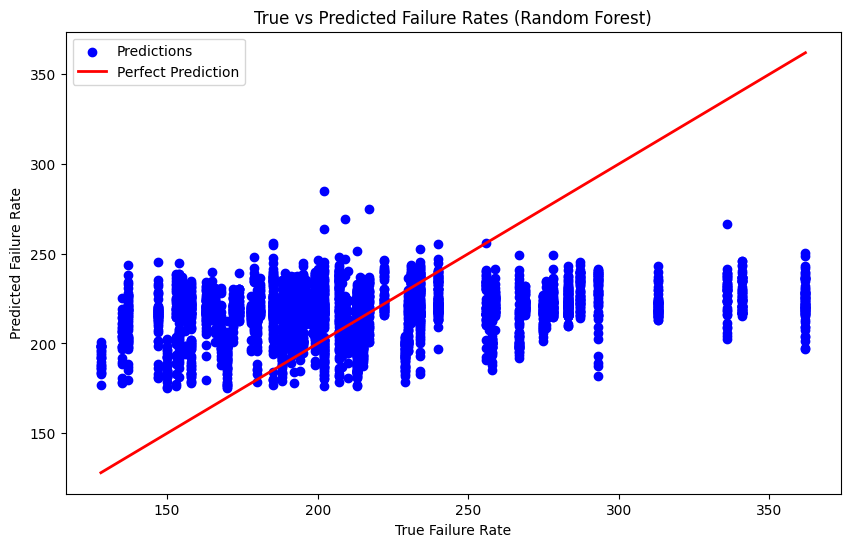

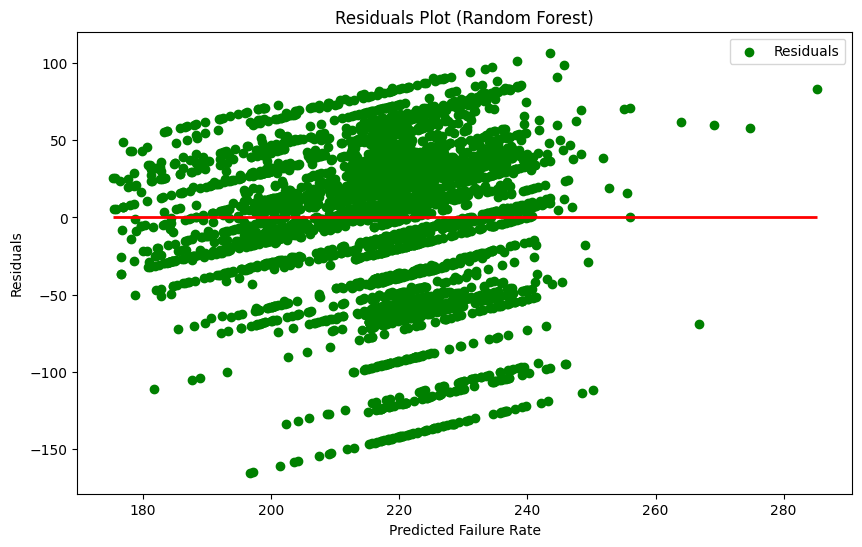

In [14]:
# Predict using the best model on the validation set
y_pred_tuned = best_model.predict(X_val)

# Calculate MSE and R2 for validation set
mse_tuned = mean_squared_error(y_val, y_pred_tuned)
r2_tuned = r2_score(y_val, y_pred_tuned)

# Print the results
print(f"Tuned Validation MSE: {mse_tuned}, R2: {r2_tuned}")
print(f"Best Parameters: {grid_search.best_params_}")

# Plot the predictions vs true values
plt.figure(figsize=(10,6))

# Plot the true vs predicted values
plt.scatter(y_val, y_pred_tuned, color='blue', label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linewidth=2, label="Perfect Prediction")

# Add labels and title
plt.xlabel('True Failure Rate')
plt.ylabel('Predicted Failure Rate')
plt.title('True vs Predicted Failure Rates (Random Forest)')
plt.legend()

# Show the plot
plt.show()

# Optional: Plot the residuals
plt.figure(figsize=(10,6))
plt.scatter(y_pred_tuned, y_pred_tuned - y_val, color='green', label='Residuals')
plt.hlines(y=0, xmin=y_pred_tuned.min(), xmax=y_pred_tuned.max(), color='red', linewidth=2)
plt.xlabel('Predicted Failure Rate')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Random Forest)')
plt.legend()
plt.show()


## KNN Regression

In [15]:
# Define threshold value
threshold = 300  

# Filter data based on threshold 
train_df_filtered = train_df[train_df['failure_time'] <= threshold]

# Define features and target after filtering
X_failure = train_df_filtered[feature_columns]  # Select only the feature columns
y_failure_time = train_df_filtered['failure_time']  # Use failure time for regression

# Split data into train and test set
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_failure, y_failure_time, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

# Train KNN regressor
knn_reg = KNeighborsRegressor(n_neighbors=10)  # Default to 10 neighbors
knn_reg.fit(X_train_reg_scaled, y_train_reg)







KNeighborsRegressor(n_neighbors=10)

Validation MSE: 1552.7575492738588, R2: -0.03393584731884203


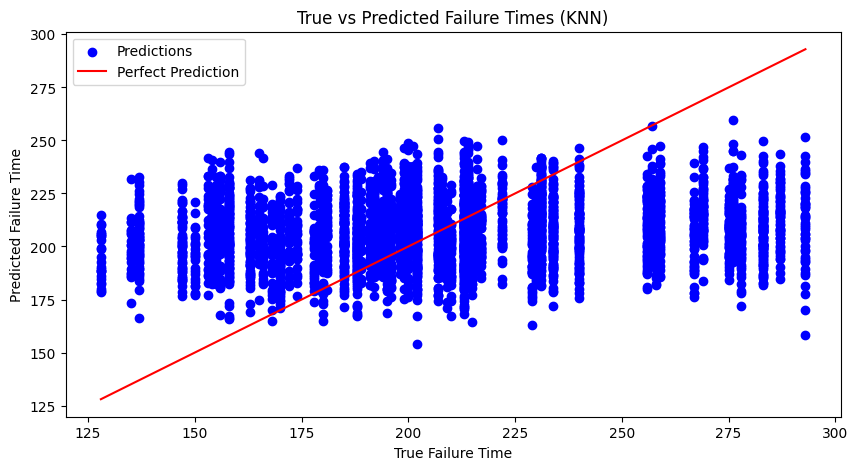

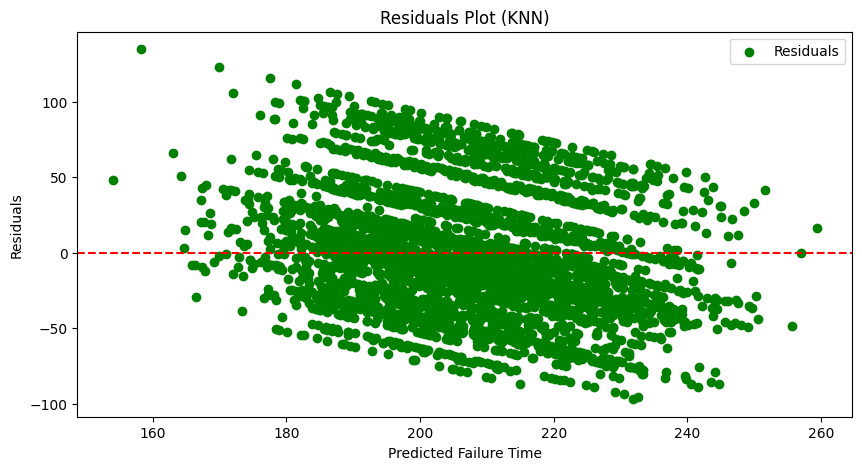

In [16]:
# Predict and find MSE
y_pred = knn_reg.predict(X_test_reg_scaled)
mse = mean_squared_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)

print(f"Validation MSE: {mse}, R2: {r2}")


# Plot True vs Predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_reg, y_pred, color='blue', label='Predictions')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r-', label='Perfect Prediction')
plt.xlabel("True Failure Time")
plt.ylabel("Predicted Failure Time")
plt.title("True vs Predicted Failure Times (KNN)")
plt.legend()
plt.show()

# Plot Residuals
residuals = y_test_reg - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Failure Time")
plt.ylabel("Residuals")
plt.title("Residuals Plot (KNN)")
plt.legend()
plt.show()

## Gradient Boosting with Lag Features

In [17]:
# Need to redo this code for some reason or it will fail
# Define column names for dataset
column_names = [
    "Unit", "ctime", "Setting1", "Setting2", "Setting3",
    "inlet_temp", "LPC_Temp_Out", "HPC_Temp_Out", "LPT_Temp_Out",
    "Fan_Pressure_In", "Total_Pressure_Bypass", "HPC_Pressure_Out",
    "Fan_Speed", "Core_Speed", "Engine_Pressure_Ratio", "HPC_Static_Pressure",
    "Fuel/Pressure_Ratio", "Fan_Speed_Correct", "Core_Speed_Correct",
    "ByPass_Ratio", "Fuel/Air_Ratio", "Bleed_Enthalpy", "Demanded_Fan_Speed",
    "Demand_Fan_Speed_Correct", "HPT_Coolant_Bleed", "LPT_Coolant_Bleed",
    "Null", "Null2"
]

# Load train and test data
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep="\s+", header=None, names=column_names)
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep="\s+", header=None, names=column_names)

# Drop unnecessary columns again
train_df.drop(columns=["Null", "Null2"], inplace=True)
test_df.drop(columns=["Null", "Null2"], inplace=True)




In [18]:
# Function to create lag-based features
def create_lagged_features(data, target_col, lag=3):
    df = data[[target_col]].copy()
    for i in range(1, lag + 1):
        df[f"lag_{i}"] = df[target_col].shift(i)
    return df.dropna()

# Store predictions temporarily
unit_predictions = []

# Process each unit
for unit in train_df["Unit"].unique():
    print(f"Processing Unit {unit}...")
    unit_data = train_df[train_df["Unit"] == unit]

    # Create lagged features
    lagged_data = create_lagged_features(unit_data, target_col="ctime", lag=3)

    # Prepare features and target
    X = lagged_data.drop(columns=["ctime"])
    y = lagged_data["ctime"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize/train the model
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)

    # Predict failure times
    y_pred = gbr.predict(X_test)

    # Store mean prediction
    mean_pred = y_pred.mean()
    unit_predictions.append((unit, mean_pred))

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Unit {unit} - Mean Squared Error: {mse:.2f}")
    
    # Plot feature importance for each unit, might keep might get rid of later in the final version
    #feature_importance = gbr.feature_importances_
    #plt.barh(X_train.columns, feature_importance)
    #plt.title(f"Feature Importance - Unit {unit}")
    #plt.show()

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(unit_predictions, columns=["Unit", "Predicted_Failure_Time"])




Processing Unit 1...
Unit 1 - Mean Squared Error: 0.98
Processing Unit 2...
Unit 2 - Mean Squared Error: 1.18
Processing Unit 3...
Unit 3 - Mean Squared Error: 1.22
Processing Unit 4...
Unit 4 - Mean Squared Error: 1.17
Processing Unit 5...
Unit 5 - Mean Squared Error: 1.65
Processing Unit 6...
Unit 6 - Mean Squared Error: 0.92
Processing Unit 7...
Unit 7 - Mean Squared Error: 1.10
Processing Unit 8...
Unit 8 - Mean Squared Error: 1.01
Processing Unit 9...
Unit 9 - Mean Squared Error: 0.97
Processing Unit 10...
Unit 10 - Mean Squared Error: 1.00
Processing Unit 11...
Unit 11 - Mean Squared Error: 1.32
Processing Unit 12...
Unit 12 - Mean Squared Error: 0.99
Processing Unit 13...
Unit 13 - Mean Squared Error: 1.10
Processing Unit 14...
Unit 14 - Mean Squared Error: 1.34
Processing Unit 15...
Unit 15 - Mean Squared Error: 1.32
Processing Unit 16...
Unit 16 - Mean Squared Error: 1.37
Processing Unit 17...
Unit 17 - Mean Squared Error: 1.23
Processing Unit 18...
Unit 18 - Mean Squared Erro

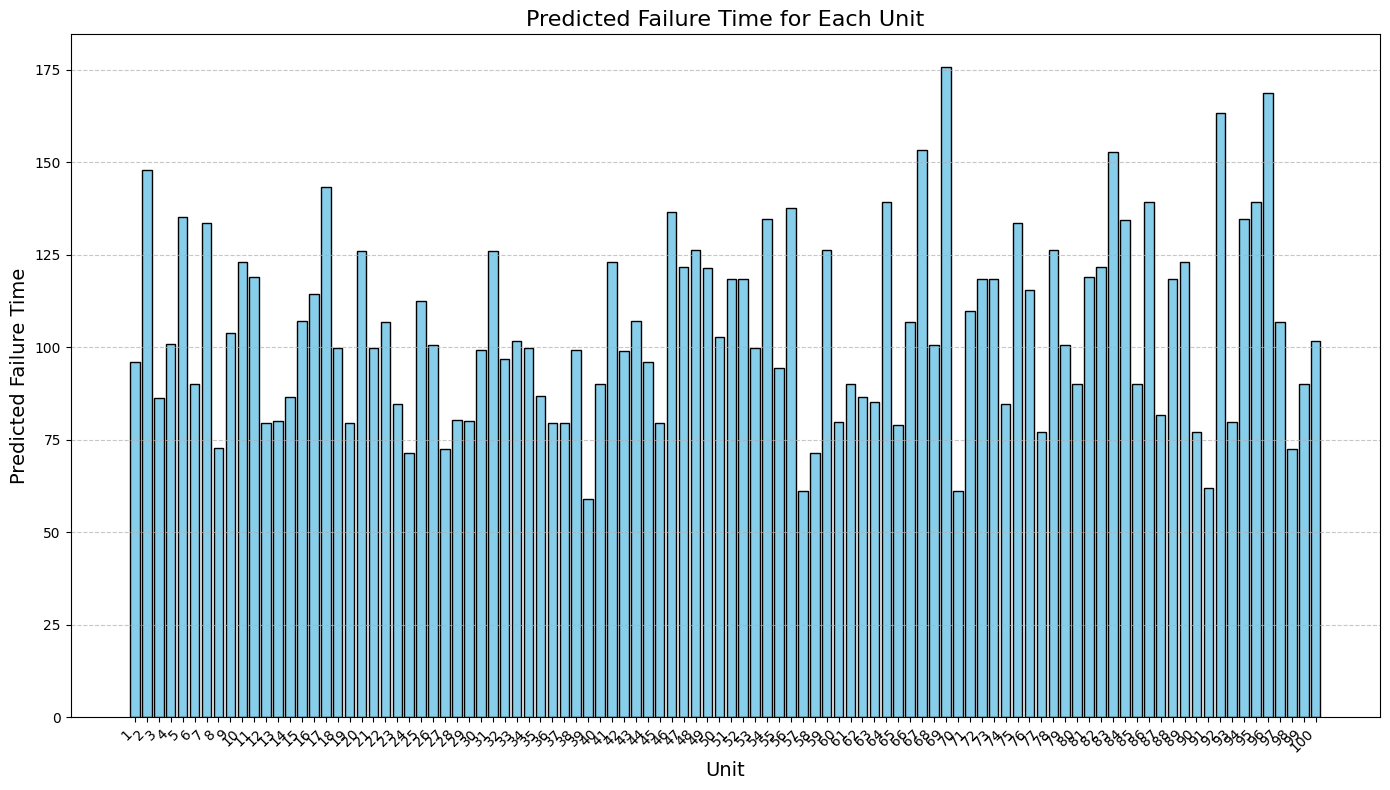

In [19]:
# Need to clean up the plot x axis
plt.figure(figsize=(14, 8))  
plt.bar(predictions_df["Unit"], predictions_df["Predicted_Failure_Time"], color="skyblue", edgecolor="black")
plt.xlabel("Unit", fontsize=14)
plt.ylabel("Predicted Failure Time", fontsize=14)
plt.title("Predicted Failure Time for Each Unit", fontsize=16)
plt.xticks(predictions_df["Unit"], rotation=45, ha="right", fontsize=10)  
plt.grid(axis="y", linestyle="--", alpha=0.7)  
plt.tight_layout()  
plt.show()


In [20]:
# Display table of units and their predicted failure times
print("Predicted Failure Times for Each Unit:")
print(predictions_df[["Unit", "Predicted_Failure_Time"]].to_string(index=False))


Predicted Failure Times for Each Unit:
 Unit  Predicted_Failure_Time
    1               95.861216
    2              147.736950
    3               86.315170
    4              100.896059
    5              135.270263
    6               90.009797
    7              133.637171
    8               72.612809
    9              103.924187
   10              123.014175
   11              118.911651
   12               79.600271
   13               80.086190
   14               86.382783
   15              106.984143
   16              114.352249
   17              143.256938
   18               99.665027
   19               79.507358
   20              125.953622
   21               99.665027
   22              106.850497
   23               84.747955
   24               71.344009
   25              112.490730
   26              100.431497
   27               72.585240
   28               80.310803
   29               80.086190
   30               99.273045
   31              125.953622
 